In [9]:
# Imports
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




loc = '/home/sh16450/code/MAR_2007-2020/'
# drifting snow mass flux (3D)
# default is g/kg, therefore divide by 1000
LQS = xr.open_dataset(loc + 'daily-LQS-MAR_ERA5-2007-2020.nc')['LQS'].sel(ATMLAY=[0.9541098, 0.9730055, 0.9844441, 0.9911561, 0.9950154], method="nearest")/1000
# cloud optical depth (COD)
COD = xr.open_dataset(loc + 'daily-COD-MAR_ERA5-2007-2020.nc')

LQS_nDS = xr.open_dataset(loc + 'daily-LQS-MAR_nDS_ERA5-2007-2020.nc')['LQS'].sel(ATMLAY=[0.9541098, 0.9730055, 0.9844441, 0.9911561, 0.9950154], method="nearest")/1000

# This yields the snow concentration due to drifting snow
diff_LQS = LQS - LQS_nDS

# Create the filter thresholds for clear-sky days based on cloud optical depth
filter_COD = 0.5
# Create the filter threshold for blowing snow conditions
# 10^(-7) kg/kg*day is based on Gerber et al. (2023), Sec 2.1
filter_qs = 10**(-5)



# sum adds +1 for every instance where clear-sky detected
# divided by the total length of the time axis gives frequency of clear skies
frequency_clear = (COD['COD'] < filter_COD).sum(dim='TIME') / np.shape(COD['COD'])[0]
time_clear = (COD['COD'] < filter_COD)

# Where is blowing snow detected?
blowing_snow = diff_LQS.where(diff_LQS >= filter_qs)
# Vertical sum of daily detected blowing snow instances
bs_vert_total = (diff_LQS > filter_qs).sum(dim='ATMLAY') # total sum of vertical detections of BS



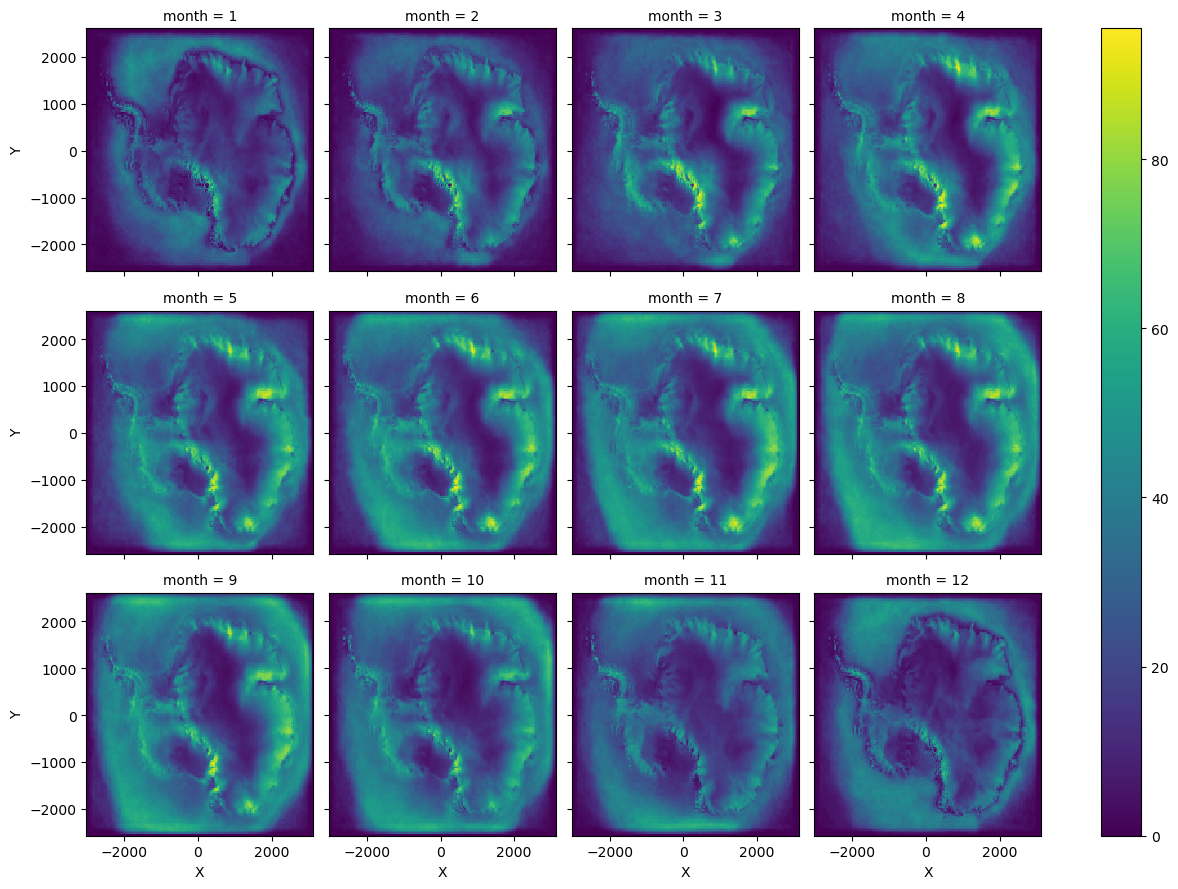

In [10]:
# LQS but cloudy days removed
LQS_no_clouds = diff_LQS.where(time_clear == True) 
# This yields 0 when false and 1 when BS is above threshold
LQS_bs_clear = (LQS_no_clouds > filter_qs) # LQS above detectable blowing snow threshold
# This keeps the actual LQS values when clear and BS detected
LQS_clear_and_bs = diff_LQS.where((time_clear == True)&(diff_LQS > filter_qs)) 
# sum of vertical layers that detected blowing snow
total_vert_bs = LQS_bs_clear.sum(dim='ATMLAY')

# True or false if at least one layer on a given day had blowing snow
vert_snow_detected = total_vert_bs > 0

# Sum per month of cloud-free BS occurences (DO NOT USE)
LQS_bs_clear_sum = LQS_bs_clear.resample(TIME='MS').sum()
# This version detects blowing snow if at least one ATMLAY has detected BS (USE THIS)
LQS_bs_clear_sum_alt = vert_snow_detected.resample(TIME='MS').sum()
# Create the actual frequencies
days_in_month = LQS_bs_clear_sum_alt.TIME.dt.daysinmonth # AMAZING :-D Gives days in each month for the frequency analysis

# Monthly frequency from 2007-01 until 2020-12
frequency_monthly_bs = LQS_bs_clear_sum_alt/days_in_month

# This creates a 12 months x Y x X mean frequency output
frequency_monthly_bs_mean = frequency_monthly_bs.groupby('TIME.month').mean(dim='TIME') * 100

frequency_monthly_bs_mean.plot(col='month', col_wrap=4)


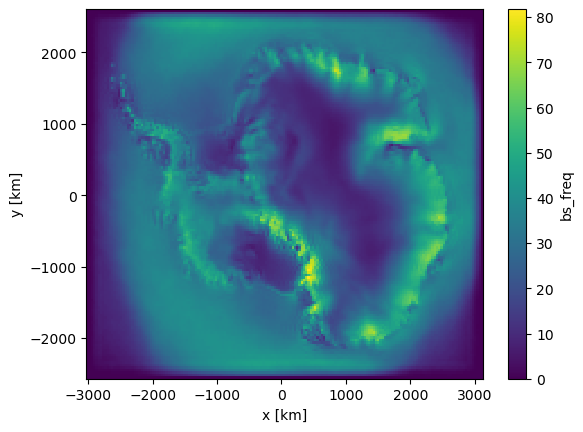

In [12]:
frequency_monthly_bs_mean.name = 'bs_freq'
frequency_monthly_bs_mean.mean(dim='month').plot()

In [14]:
frequency_monthly_bs_mean.to_netcdf('/home/sh16450/code/monthly-DSfreq-MAR_ERA5-2007-2020_new.nc')
frequency_monthly_bs_mean.to_netcdf('/home/sh16450/Documents/repos/Antarctica_clouds/Charles/monthly-DSfreq-MAR_ERA5-2007-2020_new.nc')
frequency_monthly_bs_mean

<xarray.DataArray 'bs_freq' (month: 12, Y: 148, X: 176)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * X        (X) float32 -3.01e+03 -2.975e+03 -2.94e+03 ... 3.08e+03 3.115e+03
  * Y        (Y) float32 -2.555e+03 -2.52e+03 -2.485e+03 ... 2.555e+03 2.59e+03
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12